# 深度均衡模型

--------本文尚未完成！！！---------------

本章介绍了另一类新兴的隐式层模型，即深度均衡 (DEQ) 模型 [Bai et al.,2019](https://arxiv.org/abs/1909.01377)。 这些模型最近在各种大规模视觉和NLP任务中表现出令人印象深刻的性能，通常表现出相对于现有技术的竞争性能（使用传统的显式模型）[Bai等，2020](https://arxiv.org/abs/2006.08656)。 然而，这种方法的核心思想，即指定一个层来找到某个迭代过程的不动点，可以追溯到循环反向传播中的一些原始工作 [Almeida,1987](https://www.semanticscholar.org/paper/A-learning-rule-for-asynchronous-perceptrons-with-a-Almeida/8be3f21ab796bd9811382b560507c1c679fae37f), [Pineda,1987](https://papers.nips.cc/paper/1987/file/735b90b4568125ed6c3f678819b6e058-Paper.pdf)。 因此，DEQ 模型在很大程度上是这些方法的“现代”变体，其中增加了以下概念：1) 使用现代深度架构扩展这些方法，其目标是将整个深度网络表示为均衡计算； 和 2) 试图直接通过求根而不是单独的不动点迭代来找到不动点。 
本章将介绍这些 DEQ 模型背后的直觉，讨论这些方法的一些理论方面，然后介绍使用类似 ResNet 的卷积块的方法的中等规模实现，应用于 CIFAR10。
## 深度网络和不动点方程
作为介绍 DEQ 模型的起点，我们将从一个简单的深度网络公式开始，然后使用它来激发定点迭代层的概念，就像我们最初在第 1 章中介绍的那样。  
典型的$k$层深度网络$h : \mathcal{X} \rightarrow \mathcal{Y}$由一堆层定义，如下所示$$\begin{split}
z_1 &= x \\
z_{i+1} & = \sigma(W_i z_i + b_i), \; i=1,\ldots,k-1 \\
h(x) &= W_k z_k + b_k
\end{split}$$
需要明确的是，“真正的”深度网络具有完全不同的形式，具有卷积层、残差连接、归一化、注意力层等。但是，从这样的简单网络开始，这仍然是有益的。 我们可以像下面这样以图形方式绘制这个网络：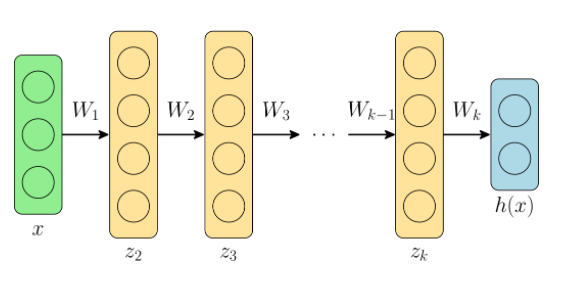
事实证明，也许有些令人惊讶（尽管我们将从数学的角度在下面显示，也许并不像它最初听起来那样令人惊讶），我们可以用相同的权重$W$替换每一层的不同$W_i$权重（并且 相同的偏差$b$)，深度网络在实践中仍然有效。 这种权重绑定网络的概念（不是在 DEQ 上下文中，而只是作为在实践中提高网络性能的一种策略），在文献中有几个例子 [Bai et al., 2018](https://arxiv.org/abs/1810.06682), [Dehghani et al., 2018](https://arxiv.org/abs/1807.03819), [Lan et al ., 2019](https://arxiv.org/abs/1909.11942)。 由于稍后会变得清楚的原因，我们还希望向这些层添加输入注入，这不仅将输入$U_x$的（线性变换）添加到第一层，还添加到其后的每一层。 在其他情况下，我们可以用方程来描述这个新模型$$\begin{split}
z_1 &= 0 \\
z_{i+1} & = \sigma(W z_i + Ux + b), \; i=1,\ldots,k-1 \\
h(x) & = W_k z_k + b_k
\end{split}$$
（由于输出$h(x)$ 可以与隐藏单元的大小不同，我们通常使用单独的权重来产生函数的最终输出），可以用图形表示如下：
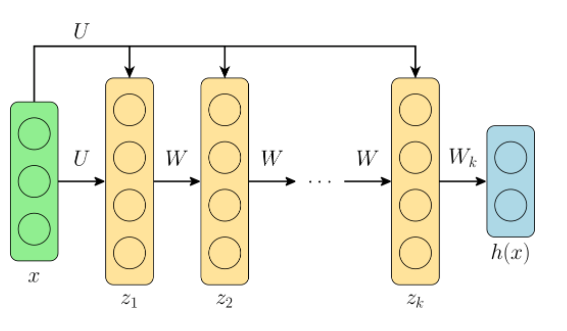
然而，现在奇怪的事情出现了。 深度网络的关键迭代是层
$$z_{i+1} = \sigma(W z_i + Ux + b).$$
重要的是，这是重复应用于隐藏单元的同一层。 如果我们无限次地重复这个更新，我们本质上就是在对上述形式的无限深网络进行建模。 但是在这个无限的极限下会发生什么呢？ 实际上，可能会发生一些不同的事情：网络输出$z_i$，$i \rightarrow \infty$可能会爆炸，并发散到较大的值； 或者，输出可能会周期性地或无序地围绕不同的值振荡； 但在实践中，我们发现对于大多数“典型”深层，值实际上收敛到一个固定点或平衡点，即一个点$z^\star$，层的进一步应用不会改变该值，即$$z^\star = \sigma(W z^\star + U x + b).$$
换句话说，这个无限深的模型看起来就像一个典型的定点迭代，我们重复更新直到值保持不变。 DEQ 模型的目标是直接找到这个平衡点 $z^\star$，不必执行前向迭代本身，而是直接尝试找到这个平衡方程的根。  
但是，为什么我们认为这样一个不动点确实存在呢？ 一个启发式的论点是，这种收敛准确地表征了常见深度网络的稳定性：由于我们已经开发了对非常深的网络已经稳定的网络架构（否则我们无法训练它们），从某种意义上说，我们已经偏向了我们的 针对倾向于稳定固定点的层进行设计。 最近的工作调查了保证存在这样一个不动点并且是唯一的 DEQ 类 [Winston and Kolter, 2020](https://arxiv.org/abs/2006.08591)。 然而，就本章而言，我们在很大程度上忽略了关于保证存在的任何形式上的陈述，而在很大程度上将这种稳定性视为一个经验问题。  
最后，这个公式还说明了为什么模型中需要输入注入$U_x$。 因为平衡点不依赖于$z_1$的任何“初始”值，如果我们没有输入注入，那么网络的输出实际上不会依赖于它的输入。 因此，输入注入作为一种方式来确保平衡点确实取决于函数的输入，尽管有一个无限深的网络。  
## DEQ 的属性：表象权力和隐性分化
定义了基本模型后，我们现在将解决有关 DEQ 模型表示能力的一些基本问题，并讨论如何应用我们在前几章中讨论的隐函数定理来计算这些 DEQ 层的梯度以及通过这些 DEQ 层的梯度。 出于本节的目的，我们将概括前面提到的 DEQ 的形式，并简单地引用 DEQ 函数 $f(z,x)$（即，在我们之前的形式中$f(x,y) = \sigma(Wz + Ux + b)$，我们试图找到一个固定点$$z^\star = f(z^\star,x).$$
### DEQ 代表的权力
DEQ表示的功能强大吗？ 也许有点令人惊讶（尽管回想起来事实很明显），我们可以非常精确地了解建立在这种平衡计算上的深层网络的表示能力。 具体来说，任何深度网络 ***(任何深度，具有任何连接性）都可以表示为单层 DEQ 模型***。 此外，这不涉及单层通用函数逼近定理中常见的指数参数膨胀：在参数数量相同的情况下，单层 DEQ 可以表示任何网络。  
这个事实的证明非常简单。 为了直观，考虑两个函数$y = g_2(g_1(x))$的传统组合。 我们可以通过简单地将这个函数的所有中间项连接成一个长向量，将其转换为单层DEQ，$$f(z,x) = f\left (\left [ \begin{array}{c}z_1 \\ z_2 \end{array} \right ], x \right ) = \left [ \begin{array}{c} g_1(x) \\ g_2(z_1) \end{array} \right ].$$
请注意，在此函数$z^\star$的平衡点，我们有$$z^\star = f(z^\star, x) \; \Longleftrightarrow \; z_1^\star = g_1(x), \;z_2^\star = g_2(z_1^\star) = g_2(g_1(x))$$
即，如果我们计算该函数的平衡点，则第二个分量$z^\star_2$正是原始级联网络的输出。 这个逻辑当然适用于任何计算图，我们可以将一个计算图的所有中间产品连接到向量$z$中，并且函数$f$是将图中“下一个”计算应用于这些元素中的每一个的函数。  
虽然这种构造在理论上显示了单个 DEQ 层的威力，但我们应该强调，这并不是我们实际使用它的构造。 例如，在这个模型中应用正常的定点迭代会比简单地计算原始网络效率低得多，而且我们无论如何都需要将整个计算向量存储在内存中（这是我们特别要避免的一个点）。 但该构造希望确实提供了一些关于为什么计算“单个”DEQ 层的均衡比单个显式层更强大的直觉。
### 您只需要一个（隐式）层
对于那些熟悉深度学习精神的人，此时您可能会想：“既然单个 DEQ 层与任意堆叠的‘显式’层一样强大，我们是否可以堆叠这些 DEQ 层以获得更强大的东西？” 不幸的是（或者幸运的是？）答案是否定的。 事实上，对于 DEQ 来说，***单个 DEQ 层是否也可以模拟任意数量的“堆叠”DEQ 层。*** 这个事实的证明与前面的例子非常相似。 假设我们有一个系统，该系统首先计算函数$z_1^\star = f_1(z_1^\star,x)$的平衡，然后使用$z_1^\star$作为输入来计算第二个平衡，即$z_2^\star = f(z_2^\star, z_1^\star)$。 然而，同样可以将这个联合问题设置为一个单一的平衡问题，即计算系统的平衡点$$z^\star = \left [ \begin{array}{c} z^\star_1 \\ z^\star_2 \end{array} \right] = \left[  \begin{array}{c} f_1(z^\star, x) \\ f_2(z_2^\star, z_1^\star) \end{array} \right ] = f(z^\star, x)$$
即，我们可以简单地连接两个均衡解决方案以获得两个解决方案的联合均衡问题的解决方案。 总的来说，这确实是平衡建模方法的一个关键优势，该操作足以描述具有单个平衡层的传统计算图（任何深度）和平衡模型（任何“深度”）。
### 均衡层的隐性分化
最后，我们得出了特定于 DEQ 模型的隐性回传形式（实际上，更普遍地针对任何固定点迭代层，但我们将主要关注此处的 DEQ 模型的具体形式）。  
正如前几章所讨论的，我们首先考虑固定点解决方案，在此处应用隐性区分$$z^\star = f(z^\star, x).$$
我们的目标是计算某些向量$y$的向量-雅可比积$\left (\frac{\partial z^\star(\cdot)}{\partial (\cdot)}\right)^T y$，其中（⋅）是我们要区分不动点的任何数量的替代相对于（即输入$x$，或函数$f$的任何参数，这两者当然都会影响最终的固定点$z^⋆$）。 由于这个向量雅可比积是在反向传播中集成这些 DEQ 层的关键方面，这样的例程允许我们将 DEQ 层集成到标准自动微分工具中。  
矢量雅可比积的推导很大程度上反映了前几章中的推导，但为了完整起见，我们在这里再次包含完整的推导。 对定点解的两边进行微分，我们有
$$\frac{\partial z^\star(\cdot)}{\partial (\cdot)} = \frac{\partial f(z^\star(\cdot), x)}{\partial (\cdot)} = \frac{\partial f(z^\star, x)}{\partial z^\star} \frac{z^\star(\cdot)}{\partial (\cdot)} + \frac{\partial f(z^\star, x)}{\partial (\cdot)}$$
其中我们使用$z^⋆(⋅)$来表示$z^⋆$被视为我们要微分的数量的隐式函数（例如，$f$的参数或输入$x$）的情况，和$z^⋆$当我们只是参考均衡值时（例如，在最后一个表达式中）。 该行中的第二个等式简单地遵循多元链式法则。 然后，重新排列项，我们得到雅可比行列式的显式表达式$$\frac{\partial z^\star(\cdot)}{\partial (\cdot)} = \left ( I - \frac{\partial f(z^\star, x)}{\partial z^\star} \right )^{-1} \frac{\partial f(z^\star, x)}{\partial (\cdot)}$$
其中所有右侧项都可以使用“传统”自动微分计算。  
最后，为了计算向量雅可比积，我们有$$\left (\frac{\partial z^\star(\cdot)}{\partial (\cdot)} \right)^T y = \left (\frac{\partial f(z^\star, x)}{\partial (\cdot)} \right )^T  \left ( I - \frac{\partial f(z^\star, x)}{\partial z^\star} \right )^{-T} y.$$
让我们考虑我们如何计算这个数量实践。 这里感兴趣的关键术语是线性系统的解（我们将其缩写为$g$）  
$$g = \left (I - \frac{\partial f(z^\star, x)}{\partial z^\star} \right )^{-T} y$$
这将重新排列为 $$g = \left(\frac{\partial f(z^\star, x)}{\partial z^\star} \right )^T g + y.$$ 
这里的关键是这个表达式实际上也是一个（线性）不动点方程，这里的量是$g$。 这里朴素前向迭代的收敛要求雅可比行列式$\frac{\partial f(z^\star, x)}{\partial z^\star}$是一个稳定的矩阵（最大特征值的幅度小于1），这也是前向迭代在其上的局部稳定性的条件 收敛点。 但是我们不会在这里过多讨论这一点，而只是依赖于一个事实，如在前向迭代中，这些迭代在实践中通常是稳定的。  
因此，导出 DEQ 层的向量雅可比积的过程可以减少到两个步骤。  
1.求解不动点方程 
$$g = \left(\frac{\partial f(z^\star, x)}{\partial z^\star} \right )^T g + y.$$
通过直接反演或（更可能）通过一些仅需乘以$\left(\frac{\partial f(z^\star, x)}{\partial z^\star} \right )^T$的迭代过程即可（这本身可以通过典型的自动微分来完成，因为它本身是向量- 雅可比积）。  
1.计算最终的雅可比向量乘积为  
$$\left (\frac{\partial z^\star(\cdot)}{\partial (\cdot)} \right)^T y = \left (\frac{\partial f(z^\star, x)}{\partial (\cdot)} \right )^T g$$
（这个乘积本身也是一个向量雅可比积，可以通过正常的自动微分计算）。
## DEQ 模型的实现
在讨论了更多的算法和理论方面后，本章的其余部分将讨论如何实现和训练 DEQ 模型，并提供一个完整的示例，该示例将在 CIFAR10 基准上训练卷积 DEQ 模型（准确率达到 81.6%，这 当然没什么了不起的，但这是一个非常小的基本模型，参数约为 200K，当然，更多涉及的 DEQ 方法可以做得更好）
## 设计层$f$
由于 DEQ 模型最终会找到单个函数$z^\star = f(z^\star, x)$的平衡点，因此$f$的选择当然将主要决定结果模型的性能。 虽然我们在一个简单的前馈层的上下文中引入了原始的 DEQ 模型$$f(z,x) = \sigma(Wz + Ux + b)$$
在实践中，我们确实希望在层中加入一些额外的结构，而不仅仅是这个通用的前馈模型。 因此，DEQ 模型的“层”应该更多地被视为一个“单元”，而不是传统意义上的真正的单层。 而且由于在深度学习模型中设计实用的单元结构（例如，Vison网络中的残余单元格，许多语言任务中的转换单元等）方面进行了大量工作，因此，DEQ函数$f$的自然选择类似地是其中之一 传统细胞。  
此外，虽然我们将函数$f$写成网络$x$实际输入的函数，但实际上我们可以预先计算应用于输入的任何变换，即预先计算$\bar{x} = Ux + b$，然后将 DEQ 函数视为一个函数$f(z,\bar{x})$，无需对输入重复应用相同的操作。 为了保持符号的一致性，尽管我们仍将 DEQ 函数称为$f(z,x)$，即使最终$x$将是输入的某个（通常只是线性）函数。  
在本章中，由于我们专注于视觉任务，我们将考虑一个残差细胞作为我们的功能。 具体来说，我们考虑如下形式：  
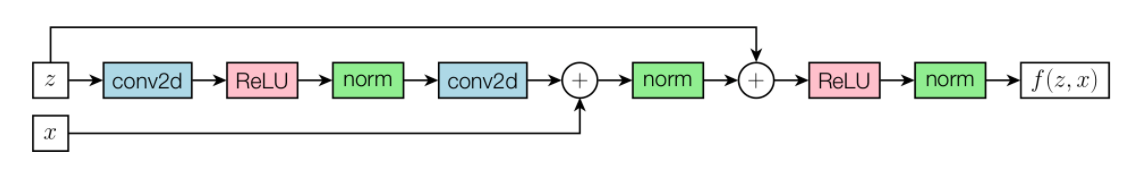
可以在功能上写成$$f(z,x) = \mathrm{norm}(\mathrm{ReLU}(z + \mathrm{norm}(x + W_2*(\mathrm{norm}(\mathrm{ReLU}(W_1 * z))))))$$
其中 ∗ 表示与滤波器$W_1$或$W_2$的卷积，**norm**表示一些归一化操作（我们在示例中使用 GroupNorm） 
DEQ 模型的另一个奇怪之处在于，这些卷积算子的权重通常需要用比传统网络中的层更小的值来初始化。 为了简单起见，我们仍然简单地将所有权重初始化为来自$\mathcal{N}(0,0.01)$的随机样本，尽管对方差项的精确理想缩放定律仍然没有很好的理解（尽管这种较小的方差初始化的合理范围很广，但效果很好)  
综上所述，我们可以使用以下代码在 PyTorch 中实现$f$函数。


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResNetLayer(nn.Module):
    def __init__(self, n_channels, n_inner_channels, kernel_size=3, num_groups=8):
        super().__init__()
        self.conv1 = nn.Conv2d(n_channels, n_inner_channels, kernel_size, padding=kernel_size//2, bias=False)
        self.conv2 = nn.Conv2d(n_inner_channels, n_channels, kernel_size, padding=kernel_size//2, bias=False)
        self.norm1 = nn.GroupNorm(num_groups, n_inner_channels)
        self.norm2 = nn.GroupNorm(num_groups, n_channels)
        self.norm3 = nn.GroupNorm(num_groups, n_channels)
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        
    def forward(self, z, x):
        y = self.norm1(F.relu(self.conv1(z)))
        return self.norm3(F.relu(z + self.norm2(x + self.conv2(y))))

本节还有一点值得一提。 一般来说，对于大多数 DEQ 应用，我们会选择上层的 `n_channels`小于 `n_inner_channels`。 这是因为，为了找到一个 DEQ 的平衡点，我们想要计算一个相对“小”的隐藏单元上的平衡点； 但另一方面，为了增加网络的代表性，我们需要相当多的参数。 实现这一目标的一种方法是让残差单元“内部”的隐藏层大于暴露于 DEQ 模型的隐藏单元。 这类似于许多深层架构（包括较大的ResNet）中常见的“瓶颈”结构，但由于有了更多的见识，我们通常希望找到相对于小型隐藏单元的固定点，因为这使得更简单（ 和更节省内存）平衡点计算。
### 前向传递的实现
DEQ 层的“前向”传递需要实际计算不动点$$z^\star = f(z^\star, x)$$
对于上面定义的函数$f$或任何其他单个单元格。 虽然在许多情况下可以通过简单地迭代前向迭代来做到这一点$$z^{k+1} = f(z^k,x)$$在实践中，有更有效的定点迭代方法，它们比朴素的前向迭代大大提高了性能，通常会有一些额外的内存成本（但通常仍然没有什么令人望而却步）。  
更常见的定点加速方法之一是 Anderson Acceleration [Walker and Ni, 2011](https://users.wpi.edu/~walker/Papers/Walker-Ni,SINUM,V49,1715-1735.pdf)。 我们将只说明算法而不是完全激励它，但这里的基本方法非常简单：而不是将$z^{k+1}$ 计算为 $f(z^k,x)$，即应用于最后一次迭代的函数$f$，将其更新为 是应用于$m$次先前迭代的$f$的某种线性组合$$z^{k+1} = \sum_{i=1}^m \alpha_i f(z^{k-i+1},x)$$
其中$α$是一组系数，其中 $\sum_{i=1}^m \alpha_i = 1$（尽管一些 $α$项也可以是负数），其中$m$是确定更新“记忆”的常数（对于前$m$次迭代，当然只有 到目前为止，每个迭代都有系数）。 为了计算$α$，我们解决了优化问题$$\DeclareMathOperator*{\minimize}{minimize}
\minimize_\alpha, \;\; \|G \alpha\|_2^2, \;\; \mbox{subject to} \;\; 1^T \alpha = 1$$
where$$G = \left [ \begin{array}{ccc} f(z^{k},x) - z^k & \cdots & f(z^{k-m+1},x) - z^{k-m+1} \end {array} \right ].$$这可以通过求解线性系统来解析求解$$\left [ \begin{array} {cc} 0 & 1^T \\ 1 & G^T G \end{array} \right ] \left [ \begin{array}{c} \nu \\ \alpha \end{array} \right ] = \left [ \begin{array}{c} 1 \\  0 \end{array} \right ].$$我们还可以进一步将迭代扩展到广义更新$$z^{k+1} = (1-\beta) \sum_{i=1}^m \alpha_i z^{k-1+1} + \beta \sum_{i=1}^m \alpha_i f(z^{k-i+1},x)$$对于某些 $β>0$。 当$β<1$时，这对应于 Anderson udpate 的“阻尼”版本，但当$β>1$时，这对应于“过度投影”版本（即，对之前的迭代具有负权重），但实际上可能 收敛更快。  
因为我们通常一次处理一批样本，所以我们通常需要在“批处理”版本中运行安德森加速来单独计算这个固定点，例如在批处理中。 该函数可以在 PyTorch 中使用以下代码实现（完全理解这段代码并不重要，但它只是实现了上面的显式求解，以便为批处理中的所有示例找到$α$的解）。  

In [ ]:
def anderson(f, x0, m=5, lam=1e-4, max_iter=50, tol=1e-2, beta = 1.0):
    """ Anderson acceleration for fixed point iteration. """
    bsz, d, H, W = x0.shape
    X = torch.zeros(bsz, m, d*H*W, dtype=x0.dtype, device=x0.device)
    F = torch.zeros(bsz, m, d*H*W, dtype=x0.dtype, device=x0.device)
    X[:,0], F[:,0] = x0.view(bsz, -1), f(x0).view(bsz, -1)
    X[:,1], F[:,1] = F[:,0], f(F[:,0].view_as(x0)).view(bsz, -1)
    
    H = torch.zeros(bsz, m+1, m+1, dtype=x0.dtype, device=x0.device)
    H[:,0,1:] = H[:,1:,0] = 1
    y = torch.zeros(bsz, m+1, 1, dtype=x0.dtype, device=x0.device)
    y[:,0] = 1
    
    res = []
    for k in range(2, max_iter):
        n = min(k, m)
        G = F[:,:n]-X[:,:n]
        H[:,1:n+1,1:n+1] = torch.bmm(G,G.transpose(1,2)) + lam*torch.eye(n, dtype=x0.dtype,device=x0.device)[None]
        alpha = torch.solve(y[:,:n+1], H[:,:n+1,:n+1])[0][:, 1:n+1, 0]   # (bsz x n)
        
        X[:,k%m] = beta * (alpha[:,None] @ F[:,:n])[:,0] + (1-beta)*(alpha[:,None] @ X[:,:n])[:,0]
        F[:,k%m] = f(X[:,k%m].view_as(x0)).view(bsz, -1)
        res.append((F[:,k%m] - X[:,k%m]).norm().item()/(1e-5 + F[:,k%m].norm().item()))
        if (res[-1] < tol):
            break
    return X[:,k%m].view_as(x0), res

让我们看看这在实践中是什么样子。 我们可以尝试评估某个随机输入$x$的定点迭代，绘制所有批次的平均（相对）残差$$\frac{\|f(z^k,x) - z^k\|_2}{\|f(z^k,x)\|_2}$$对于每次迭代

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

X = torch.randn(10,64,32,32)
f = ResNetLayer(64,128)
Z, res = anderson(lambda Z : f(Z,X), torch.zeros_like(X), tol=1e-4, beta=1.0)
plt.figure(dpi=150)
plt.semilogy(res)
plt.xlabel("Iteration")
plt.ylabel("Relative residual")

我们可以将其与朴素的前向迭代进行比较，以了解 Anderson 加速的一些优势。 因为这个系统$m$相对稳定，差异（2倍迭代）不是那么大，但随着完整DEQ模型训练的进行，安德森加速和简单前向交互之间的差异变得更加明显。

In [ ]:
def forward_iteration(f, x0, max_iter=50, tol=1e-2):
    f0 = f(x0)
    res = []
    for k in range(max_iter):
        x = f0
        f0 = f(x)
        res.append((f0 - x).norm().item() / (1e-5 + f0.norm().item()))
        if (res[-1] < tol):
            break
    return f0, res

Z, res = forward_iteration(lambda Z : f(Z,X), torch.zeros_like(X), tol=1e-4)
plt.figure(dpi=150)
plt.semilogy(res)
plt.xlabel("Iteration")
plt.ylabel("Relative residual")

### 实现向后传递
如上所述，反向传播需要我们首先找到线性不动点方程的解$$g = \left(\frac{\partial f(z^\star, x)}{\partial z^\star} \right )^T g + y.$$然后我们计算最终的向量雅可比乘积为$$\left (\frac{\partial z^\star(\cdot)}{\partial (\cdot)} \right)^T y = \left (\frac{\partial f(z^\star, x)}{\partial (\cdot)} \right )^T g.$$每个这些项中的两个向量雅可比积 $\left(\frac{\partial f(z^\star, x)}{\partial z^\star} \right )^T g$ 和 $\left (\frac{\partial f(z^\star, x)}{\partial (\cdot)} \right )^T g$ 都是“标准”向量雅可比积 可以使用现有的自动微分工具进行计算。  
这意味着在像 PyTorch 这样的库中实现一个能够使用任何函数$f$ 的通用 DEQ 层实际上非常简单。 所有这些都可以在标准的 `nn.Module `类中完成（而不是例如需要单独实现向前/向后传递的显式 `autograd.Function `类），利用内置的自动微分工具来计算所有需要的导数。 它基本上包括三个步骤，我们在第 1 章中以一种不太通用（也不太优雅，因为我们明确计算雅可比行列式）的形式进行了描述，但现在我们再次强调。  
1.计算固定点 $z^\star = f(z^\star,x)$（使用例如 Anderson 加速度），在 autodiff 磁带之外（在 PyTorch 中，这意味着在 `with torch.no_grad(): `块内运行它）。  
2.通过在平衡点调用$z := f(z,x)$一次来重新接合 autodiff 带。 这使用现有的自动微分库来计算 $\left (\frac{\partial f(z^\star, x)}{\partial (\cdot)} \right )^T$ 乘法。  
3.添加一个反向钩子，它采用传入的反向梯度 y 并再次使用例如求解不动点方程$g = \left(\frac{\partial f(z^\star, x)}{\partial z^\star} \right )^T g + y$。 安德森加速。 总的来说，代码很短，如下所示。

In [ ]:
import torch.autograd as autograd

class DEQFixedPoint(nn.Module):
    def __init__(self, f, solver, **kwargs):
        super().__init__()
        self.f = f
        self.solver = solver
        self.kwargs = kwargs
        
    def forward(self, x):
        # compute forward pass and re-engage autograd tape
        with torch.no_grad():
            z, self.forward_res = self.solver(lambda z : self.f(z, x), torch.zeros_like(x), **self.kwargs)
        z = self.f(z,x)
        
        # set up Jacobian vector product (without additional forward calls)
        z0 = z.clone().detach().requires_grad_()
        f0 = self.f(z0,x)
        def backward_hook(grad):
            g, self.backward_res = self.solver(lambda y : autograd.grad(f0, z0, y, retain_graph=True)[0] + grad,
                                               grad, **self.kwargs)
            return g
                
        z.register_hook(backward_hook)
        return z

对于熟悉 PyTorch 的人，您可能会注意到我们更喜欢直接调用 `autograd.grad`（而不是高阶函数` autograd.functions.vjp` 等），因为它可以让我们重复乘以这个雅可比行列式，而无需重新运行前向传递。 这里的简单性的一个小缺点是，它确实需要两次额外的 $f$调用，而不是严格必要的：一次是按照上面步骤 2 中的描述重新使用梯度带，一次是设置` f0 `变量（需要 与 `z`) 分开。 然而，考虑到我们通常需要多次调用$f$来进行前向求解本身，这增加了相对较少的计算开销。  
为了验证该层是否正确计算梯度，我们可以使用 `gradcheck `函数来验证解析梯度是否与数值计算的梯度匹配。 请注意，由于我们以这种有点非标准的方式（与 `autograd.Function` 类相反）使用了 `nn.Module`，这将仅测试与层 $x$的输入相关的梯度（而不是与参数相关的）），不过我们也可以通过设置单独的功能（如果需要）来进行验证。 我们还应该强调，上面的函数不适用于双重反向传播，尽管如果需要，可以再次使用一些额外的效果来解决这个问题。

In [ ]:
from torch.autograd import gradcheck
# run a very small network with double precision, iterating to high precision
f = ResNetLayer(2,2, num_groups=2).double()
deq = DEQFixedPoint(f, anderson, tol=1e-10, max_iter=500).double()
gradcheck(deq, torch.randn(1,2,3,3).double().requires_grad_(), eps=1e-5, atol=1e-3, check_undefined_grad=False)

最后，让我们看一下使用上面的层来计算前向和后向传递，并查看前向和后向迭代的相对残差。

In [ ]:
f = ResNetLayer(64,128)
deq = DEQFixedPoint(f, anderson, tol=1e-4, max_iter=100, beta=2.0)
X = torch.randn(10,64,32,32)
out = deq(X)
(out*torch.randn_like(out)).sum().backward()

In [ ]:
plt.figure(dpi=150)
plt.semilogy(deq.forward_res)
plt.semilogy(deq.backward_res)
plt.legend(['Forward', 'Backward'])
plt.xlabel("Iteration")
plt.ylabel("Residual")

在这里我们看到（也许并不奇怪，因为它解决的是线性系统而不是非线性系统），后向传递通常比前向传递收敛得更快； 然而，这在实践中并不总是如此，事实上我们将在下面看到，在训练之后，反向传播实际上经常收敛到比正向传播更低的精度。
## 训练你的 DEQ
最后让我们把所有这些放在一起，在 CIFAR10 上实际训练一个卷积 DEQ 模型。 以下代码在单个 GPU 上运行需要几个小时，对于仅实现略高于 80% 的准确率的模型来说，这可能看起来过于冗长，但我们应该做出以下警告：  
1.我们在这里在 CIFAR10 上有效地运行了一个完全卷积网络，它在没有下采样的情况下为整个 32x32 图像保持了合理的大通道。 大多数合理的网络在拥有任何高通道数层之前都会进行大量下采样，虽然我们当然也可以为 DEQ 这样做，但我们想强调一个模型的简单性，该模型仅在原始输入尺度上执行卷积。  
2.模型非常小，参数不到100K。 这种大小的 ResNets 达到了相当的准确度。  
3.我们没有使用数据增强（尽管对于这么小的模型，添加数据增强只会带来相对较小的好处）。  
解决上述这两点，并结合一个单元$f$在多个尺度上集成信息，就可以获得与现有技术相媲美的结果 [Bai et al., 2020](https://arxiv.org/abs/2006.08656)（不过，应该强调的是，运行时确实仍然 比具有相同参数数量的可比较的前馈模型慢）。  
以下模型演示了我们考虑的完整 DEQ 模型，其中一个 DEQ 层应用于上述残差单元，一个卷积输入注入，以及一个在 DEQ 输出平均池化后应用的线性层。 在实践中，在 DEQ 层之前和之后应用某种形式的归一化也很重要：这里我们简单地使用 Batch Norm，它可以很好地“标准化”定点迭代所看到的输入大小。  

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)
chan = 48
f = ResNetLayer(chan, 64, kernel_size=3)
model = nn.Sequential(nn.Conv2d(3,chan, kernel_size=3, bias=True, padding=1),
                      nn.BatchNorm2d(chan),
                      DEQFixedPoint(f, anderson, tol=1e-2, max_iter=25, m=5),
                      nn.BatchNorm2d(chan),
                      nn.AvgPool2d(8,8),
                      nn.Flatten(),
                      nn.Linear(chan*4*4,10)).to(device)

现在让我们包含样板数据加载器和训练代码。 这里没有什么特别花哨的地方：我们没有数据增强、余弦退火学习率计划，以及使用 Adam 优化器进行 50 次训练（这些元素都很有可能得到改进）。

In [ ]:
# CIFAR10 data loader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

cifar10_train = datasets.CIFAR10(".", train=True, download=True, transform=transforms.ToTensor())
cifar10_test = datasets.CIFAR10(".", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(cifar10_train, batch_size = 100, shuffle=True, num_workers=8)
test_loader = DataLoader(cifar10_test, batch_size = 100, shuffle=False, num_workers=8)

In [ ]:
# standard training or evaluation loop
def epoch(loader, model, opt=None, lr_scheduler=None):
    total_loss, total_err = 0.,0.
    model.eval() if opt is None else model.train()
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
            lr_scheduler.step()
                
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]

    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

下面的代码现在将在 50 个 epoch 中将模型训练到约 81% 的准确度。 同样，这段代码在单个 GPU 上运行需要几个小时（在 Colab 中可能需要更长的时间），但它希望给人一种构建这些中等规模的 DEQ 模型相对容易的印象。

In [ ]:
import torch.optim as optim
opt = optim.Adam(model.parameters(), lr=1e-3)
print("# Parmeters: ", sum(a.numel() for a in model.parameters()))

max_epochs = 50
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*len(train_loader), eta_min=1e-6)

for i in range(50):
    print(epoch(train_loader, model, opt, scheduler))
    print(epoch(test_loader, model)) 